# Decision Tree for N-dimensional data and labels
The code below implements a decision tree calculated on all the data, for one label depending on several independent variables.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import log, e
import random
import sys


### Custom Libraries

In [10]:
import density_tree as dt

The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


# Unsupervised entropy with unlabelled clusters
Below are some functions that compute an optimal split for unlabelled data, using the differential entropy of a d-variate Gaussian density. 

First, let's generate some unlabelled data:


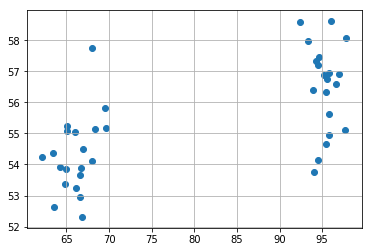

In [65]:
dimensions = 2
nclusters = 2
covariance = 2
npoints = 20
minrange = 0
maxrange = 100

dataset, clusters = dt.create_data.createData(nclusters, dimensions, covariance, npoints)
dataset=dataset[:,:-1]
plt.scatter(dataset[:,0],dataset[:,1],)
plt.grid()
plt.show()

Now, we want to get the best split, say, along the x-axis.

test set for differential Gaussian entropy function

In [67]:
plotData_tree_split(dataset, title="Training Data", linesX = [split_vals_opt], linesY=[], labels = False) 

NameError: name 'plotData_tree_split' is not defined

# Labelled data

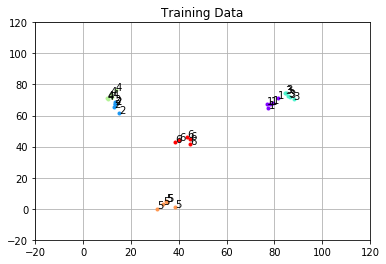

In [83]:
# cluster parameters
nclusters=6
dimensions=2
covariance=5
minRange=0
maxRange=100
npoints=5

    
dataset, clusters = dt.create_data.createData(nclusters, dimensions, covariance, npoints,)
dt.plots.plotData(clusters, title="Training Data", clusters=clusters,
                  minRange = minRange, maxRange = maxRange, covariance=covariance)

### Calculate the entropy over all possible split values in all dimensions (`calc_entropy attribute`)


Now we can iterate the same procedure over the both splitted sides until there is no split left.

In [183]:
# Binary tree node to save binary tree nodes
class Node:
    """
    constructor for new nodes
    # decision rule is the rule which splits labels in two groups labels_left and labels_right
    # left_rule and right_rule are pointers to the rules that have to be used 
    # to further split labels_left and labels_right
    """

    def __init__(self):
        # data for node
        self.parent = None  # parent node
        self.split_value = None  # the split value
        self.dimension = None  # the split dimension
        self.labels = None  # the labels contained at this split level

        # child nodes
        self.left = None  # node to the left, e.g., for value < split_value
        self.left_labels = None
        self.right = None
        self.right_labels = None

    def traverse_inorder(self):
        # TODO test
        if self.left is not None:
            self.left.traverse_inorder()
        self.__format__()
        if self.right is not None:
            self.right.traverse_inorder

    def traverse_preorder(self):
        # TODO test
        self.__format__()
        if self.left is not None:
            self.left.traverse_preorder()
        if self.right is not None:
            self.right.traverse_preorder()

    def traverse_postorder(self):
        # TODO implement
        raise NotImplementedError

    def __format__(self):
        # print("rule: " + self.decisionrule) # print a decision rule on one line as a string (e.g., `d(2) < 20`)
        print("labels: " + str(self.labels))
        print("dimension: " + str(self.dimension))
        print("split value: " + str(self.split_value))
        if self.left is not None:
            print("has left")
        if self.right is not None:
            print("has right")


In [184]:
"""Functions for entropy and splitting"""

import numpy as np
import pandas as pd


def split(dataset, index, split_value):  # [2]
    """
    split a dataset (columns: variables, rows: data) in two according to some column (index) value.
    :param dataset: input dataset
    :param index: index of dimension to split values on
    :param split_value: value of the dimension where the dataset is split
    :return: left and right split datasets
    """
    left, right = list(), list()
    for row in dataset:
        if row[index] < split_value:
            left.append(row)
        else:
            right.append(row)
    return left, right


def entropy(labels, base=np.e):  # [1]
    """
    Calculate the entropy for a set of labels.
    :param labels: an array of labels
    :param base: base of entropy, by default e
    :return: entropy
    """
    value, counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log(norm_counts) / np.log(base)).sum()

def entropy_discrete(dataset, dim):
    """
    calculate the entropy values for all cuts on one attribute (left<cut, right>=cut).
    :param dataset: Input array with data and label in rows. The last column contains the labels.
    :param dim: The index of the column for which the entropy should be computed.
    :return: entropy values, corresponding split values
    """
    x_vals, entropy_vals = list(), list()
    uniquevals = (np.unique(dataset[:, dim]))
    left_labels_unique, right_labels_unique = list(), list()
    
    # loop all possible split values
    for split_x in uniquevals[1:]:
        # append value
        x_vals.append(split_x)

        # split on value
        left, right = split(dataset, dim, split_x)
        left = np.asarray(left)
        right = np.asarray(right)

        # labels
        left_labels = left[:, -1]  # last column = labels
        right_labels = right[:, -1]

        # unique labels
        left_labels_unique.append(np.unique(left_labels))
        right_labels_unique.append(np.unique(right_labels))

        # entropy for split
        left_entropy = entropy(left_labels, base=2)
        right_entropy = entropy(right_labels, base=2)

        # total entropy for attribute
        # TODO change to information gain
        entropy_attr_split = left_entropy * len(left) / len(dataset) + right_entropy * len(right) / len(dataset)
        entropy_vals.append(entropy_attr_split)

    return entropy_vals, x_vals, left_labels_unique, right_labels_unique


def data_to_clusters(dataset):
    """Helper function to get clusters from estimated labels"""
    clusters = []
    for val in np.unique(dataset[:, 2]):
        clusters.append(dataset[dataset[:, 2] == val])
    return clusters


def get_unique_labels(labels):
    ul_side, ul_side_c = [], []

    for i in labels:
        ul_side_c.append(len(np.unique(i)))  # count of unique values on right side
        if len(np.unique(i)) == 1:  # if there is only one label, print the label
            ul_side.append(i)
        else:  # if there are several labels, print the number of the labels
            ul_side.append(i)
            # ul_side.append('several')
    return ul_side, ul_side_c


def calc_entropy_attribute(dataset):
    '''find the lowest entropy for a given attribute'''
    dfs = []
    entropy_attr = []
    x_attr = []

    for attribute_ind in range(np.shape(dataset, )[1] - 1): # loop over all attributes

        # get the entropy for all cuts
        entropy_vals_attr, xs_vals_attr, left_l_unique, right_l_unique = entropy_discrete(dataset,attribute_ind)
        # get number of unique labels (= cluster) on both sides
        ul_l, ul_l_c = get_unique_labels(left_l_unique)
        ul_r, ul_r_c = get_unique_labels(right_l_unique)

        # append values for all splits to dataframe
        x_attr.append(xs_vals_attr)
        entropy_attr.append(np.asarray(entropy_vals_attr))
        
        df = pd.DataFrame({'cut value': x_attr[attribute_ind],
                           'entropy': list(entropy_attr[attribute_ind]),
                           'left clusters': ul_l_c,
                           'right clusters': ul_r_c,
                           'left labels': ul_l,
                           'right labels': ul_r},
                          columns=['cut value', 'entropy', 'left clusters',
                                   'right clusters', 'left labels', 'right labels'])
        df.reset_index(inplace=True)
        dfs.append(df)
        
    return dfs


def get_best_attr(dfs):
    """get the attribute cutting which the information gain is highest"""
    min_e = np.infty

    for i in range(len(dfs)):  # loop all variables
        df = dfs[i]
        min_df_attr = df.loc[df['entropy'].argmin()]
        if min_df_attr['entropy'] < min_e:
            min_e = min_df_attr['entropy']
            min_df = pd.DataFrame(min_df_attr.drop("index")).transpose()
            min_df["dimension"] = i

    return min_df  # value of lowest entropy after possible cut, cut value, dimension


def next_split(left, right, results, root):
    """
    recursive method to split variables on dimension until all variables are contained in one subspace. G
    1. Get left (l) and right (r) based on split
    2. Check if labels unique
    3. Get entropies for all split values in ll rr
    4. Recurse -> 1.
    """
    for side in (left, right):  # loop both sides
        dt_node = Node() # decision tree node]
        dt_node.parent = root

        dt_node.labels = np.asarray(side)[:, -1]  # get variables (in last column)
        side = np.asarray(side)
        if len(np.unique(np.asarray(side)[:, 2])) != 1:  # if there are still more than one labels in a side
            dfs = calc_entropy_attribute(side)  # get entropies for all attributes within side
            min_df = get_best_attr(dfs)  # get best split value
            
            dt_node.split_value = min_df["cut value"].values[0]
            dt_node.dimension = min_df["dimension"].values[0]
            if np.array_equal(left, side):
                dt_node.parent.left = dt_node
            elif np.array_equal(right, side):
                dt_node.parent.right = dt_node
            left_new, right_new = split(side, 
                                        min_df["dimension"].values[0],
                                        min_df["cut value"].values[0]) # get new left and right labels
            # save results for dataframe
            results.append(min_df)
            next_split(left_new, right_new, results, dt_node)  # split, recursion


In [185]:
# get left (l) and right (r) based on split
# check if labels unique 
# get entropies for all split values in ll rr
# recurse            
            
# initial split
def create_decision_tree(dimensions = 0, subsample = 0):
    """create decision tree be performing initial split, then recursively splitting until all labels are in unique bins"""
    # TODO modify such as to take as entry number of variables to create tree on, number of data subsamples etc.
    
    root = Node() # initial node
    # initial split
    dfs = calc_entropy_attribute(dataset)
    min_df = get_best_attr(dfs)
    
    root.split_value = min_df["cut value"].values[0]
    root.dimension = min_df["dimension"].values[0]
    root.labels = dataset[:,-1]
    left,right=split(dataset, 
                 min_df["dimension"].values[0], # dimension of min cut value
                 min_df["cut value"].values[0]) # min cut value
    results=[min_df]
    
    # recursively continue splitting
    next_split(left, right, results, root) # iterate
    return results, root

results, root = create_decision_tree()
#df_results=pd.concat(results)

In [188]:
root.traverse_preorder()

labels: [ 1.  1.  1.  1.  1.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.]
dimension: 0
split value: 31.1186115962
has left
has right
labels: [ 2.  2.  2.  2.  2.  4.  4.  4.  4.  4.]
dimension: 1
split value: 70.4415159843
labels: [ 1.  1.  1.  1.  1.  3.  3.  3.  3.  3.  5.  5.  5.  5.  5.  6.  6.  6.
  6.  6.]
dimension: 0
split value: 76.8395407102
has left
has right
labels: [ 5.  5.  5.  5.  5.  6.  6.  6.  6.  6.]
dimension: 1
split value: 41.8918802521
labels: [ 1.  1.  1.  1.  1.  3.  3.  3.  3.  3.]
dimension: 0
split value: 84.5672055421


,cut value,entropy,left clusters,right clusters,left labels,right labels,dimension
14,61.0692,1.58496,3,3,"[3.0, 4.0, 5.0]","[1.0, 2.0, 6.0]",0
4,8.53367,0.666667,1,2,[5.0],"[3.0, 4.0]",0
4,52.9096,-0,1,1,[4.0],[3.0],0
9,88.7964,0.666667,2,1,"[1.0, 2.0]",[6.0],0
4,51.2133,-0,1,1,[1.0],[2.0],1


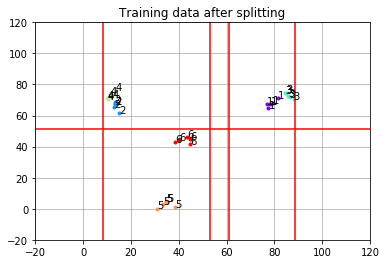

In [189]:
x_split=df_results[df_results["dimension"]==0]["cut value"].values
y_split=df_results[df_results["dimension"]==1]["cut value"].values

display(df_results)
dt.plots.plotData_tree_split(clusters, x_split, y_split, title="Training data after splitting",
                            minRange = minRange, maxRange = maxRange, covariance=covariance)

Visualize decision tree structure

We will now set up a data structure to save the decision strucutre, left and right labels and pointers to the next decision rule.

We will now extract the decision tree according to the explanations below.

In [133]:
decision_tree[0].split_value

61.069189053511657

In [124]:
def decision_string(ind, df):
        """print a decision rule on one line as a string (e.g., `d(2) < 20`)"""
        thisrow = df.iloc[ind]
        other_dim=thisrow.loc["dimension"]
        other_val=thisrow.loc["cut value"]
        string = "d(" + str(other_dim) + ") < " + str(other_val)
        return string

def traverse_tree(df,decision_tree):
    # initialize new node
    node = Node()
    
    # get labels left and right
    labels = np.asarray(df[["left labels","right labels"]].values) 
    labels_left=labels[0,0]
    labels_right=labels[0,1]

    # get splt value, dimensino and left / right labels from df
    # TODO create decision tree directly in recursive split 
    node.dimension=df.iloc[0].loc["dimension"]
    node.split_value=df.iloc[0].loc["cut value"]
    node.left_labels=labels_left
    node.right_labels=labels_right

    for i, row in enumerate(labels[1:,:]):
        thisrow_labels_left = labels[0,0] # labels of this row, e.g., [2, 3, 6]
        thisrow_labels_right = labels[0,1] # labels of this row, e.g., [2, 3, 6]

        otherrow = np.concatenate(row) # labels of other row, e.g., [2, 3, 6]
        if len(np.setdiff1d(thisrow_labels_left,otherrow))==0: # one of the rows below contains all values of the current topmost row
            node.left = decision_string(i+1)
        elif len(np.setdiff1d(thisrow_labels_right,otherrow))==0:
            node.right = decision_string(i+1)

    decision_tree.append(node)
    if len(labels)>1:
        traverse_tree(df.iloc[1:,:],decision_tree)

def create_decision_tree(df):
    """create decision tree"""
    decision_tree=[]
    traverse_tree(df,decision_tree)
    return decision_tree

decision_tree=create_decision_tree(df_results)

We can see that using the splits above, all clusters can be partitioned into subregions.

## Test data set on regular grid
Next, we want to estimate the label of a new data point from the decision tree just built. We will always follow the path of strongest reduction of entropy.

In [126]:
decision_tree[0].__format__()

dimension: 0
split value: 61.0691890535
left labels after split: [ 3.  4.  5.]
right labels after split: [ 1.  2.  6.]
next decision rule left: d(0) < 8.53367100102
next decision rule right: d(0) < 88.7964480094


In [134]:
def descend_decision_tree(data_test, node, decision_tree):
    """given some test data and decision tree, assign the correct label using a decision tree"""
    
    # check left or right side
    if data_test[node.dimension] < node.split_value:  # split to the left
        if len(node.left_labels) == 1:  # if there is only one label, return it
            return int(node.left_labels)
        else:
            if node.left is not None:  # else descent
                return descend_decision_tree(data_test, node.left, decision_tree)
    else:  # split to the right
        if len(node.right_labels) == 1:
            return int(node.right_labels)
        else:
            if node.right is not None:
                return descend_decision_tree(data_test, node.right, decision_tree)

In [135]:
dataset_test_eval=[]
spacing=3
for i in [[x,y] for x in range(-10,60,spacing) for y in range(-10,60,spacing)]:
    label=descend_decision_tree(i,decision_tree[0], decision_tree)
    dataset_test_eval.append(np.concatenate([i,[label]]))
dataset_test_eval=np.asarray(dataset_test_eval)

AttributeError: 'str' object has no attribute 'dimension'

In [101]:
dataset_test_eval

array([[-10, -10, None],
       [-10, -7, None],
       [-10, -4, None],
       ..., 
       [59, 53, None],
       [59, 56, None],
       [59, 59, None]], dtype=object)

In [100]:
clusters_eval=data_to_clusters(dataset_test_eval)
plotData_tree_split(clusters_eval, x_split, y_split, "Test Data and Splits of Training Data")
plotData_tree_split(clusters,x_split,y_split, "Training Data and Splits")

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'